In [1]:
!pip install yfinance
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15192 sha256=134d95ff2f48740ef7af10e6c5814e8898c4bb6747d13f97c9c578d79d781bb1
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


In [73]:
# necessary imports
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import date
from heapq import nlargest
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
import statistics

In [3]:
# inputs to be taken from app
m = 100   # number of days to measure stock performance for sample strategy
n = 10    # number of top stocks to be selected for sample strategy
initial_equity = 1000000
format = '%b %d %Y'
start_date_sim = datetime.strptime('Oct 1 2022', format)  # start date for simualtion
end_date_sim = datetime.strptime('Oct 20 2022', format)  # end date for simulation
start_date_sim = start_date_sim.date()
end_date_sim = end_date_sim.date()

In [4]:
# getting dates for downloading stock data based on maximum of simulation period and stock performance period
sim_days = end_date_sim - start_date_sim
sim_days = sim_days.days
max_data = max(sim_days, m)
max_data = max_data + 1
print(max_data)
today = date.today()
start_date = today - timedelta(days = max_data)
print(start_date)

101
2022-07-23


In [5]:
stock_list = ['INFY.NS', 'UPL.NS', 'JSWSTEEL.NS', 'HINDUNILVR.NS', 'LT.NS', 'CIPLA.NS', 'ITC.NS', 'BAJAJFINSV.NS', 
         'BAJFINANCE.NS', 'WIPRO.NS', 'SBILIFE.NS', 'ASIANPAINT.NS', 'M&M.NS', 'ONGC.NS', 'HCLTECH.NS', 'TCS.NS', 
         'HEROMOTOCO.NS', 'DRREDDY.NS', 'HDFCLIFE.BO', 'BHARTIARTL.NS', 'DIVISLAB.NS', 'AXISBANK.NS', 'ADANIENT.NS', 
         'BPCL.NS', 'ICICIBANK.NS', 'TECHM.NS', 'NTPC.NS', 'TITAN.NS', 'GRASIM.NS', 'SUNPHARMA.NS', 'NESTLEIND.NS', 
         'TATAMOTORS.NS', 'HINDALCO.NS', 'ULTRACEMCO.NS', 'BRITANNIA.NS', 'BAJAJ-AUTO.NS', 'RELIANCE.NS', 'POWERGRID.NS', 
         'SBIN.NS', 'COALINDIA.NS', 'TATACONSUM.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFC.NS', 'HDFCBANK.NS', 
         'MARUTI.NS', 'APOLLOHOSP.NS', 'TATASTEEL.NS', 'EICHERMOT.NS', 'ADANIPORTS.NS']

nifty_df = yf.download('^NSEI', start = start_date, end = today)
nifty_df['stock_name'] = '^NSEI'
print(nifty_df)

stock_df = yf.download(stock_list[0], start = start_date, end = today)
stock_df['stock_name'] = stock_list[0]
for i in range(1,50):
  stock_df2 = yf.download(stock_list[i], start = start_date, end = today)
  stock_df2['stock_name'] = stock_list[i]
  stock_df = stock_df.append(stock_df2)
print(stock_df)

[*********************100%***********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2022-07-25  16662.550781  16706.050781  16564.250000  16631.000000   
2022-07-26  16632.900391  16636.099609  16463.300781  16483.849609   
2022-07-27  16475.349609  16653.449219  16438.750000  16641.800781   
2022-07-28  16774.849609  16947.650391  16746.250000  16929.599609   
2022-07-29  17079.500000  17172.800781  17018.150391  17158.250000   
...                  ...           ...           ...           ...   
2022-10-24  17736.349609  17777.550781  17707.400391  17730.750000   
2022-10-25  17808.300781  17811.500000  17637.000000  17656.349609   
2022-10-27  17771.400391  17783.900391  17654.500000  17736.949219   
2022-10-28  17756.400391  17838.900391  17723.699219  17786.800781   
2022-10-31  17910.199219  18022.800781  17899.900391  18012.199219   

               Adj C

In [6]:
nifty_df.reset_index(inplace = True)
stock_df.reset_index(inplace = True)

In [7]:
max_date = stock_df['Date'].max()
min_date = stock_df['Date'].min()
print(max_date)
print(min_date)

2022-10-31 00:00:00
2022-07-25 00:00:00


In [8]:
# getting m day performance of stocks
perf_index = []
dict_mday_performance = {}
for i in range(0,50):
  early_df = stock_df.loc[(stock_df['stock_name'] == stock_list[i]) & (stock_df['Date'] == min_date)]
  later_df = stock_df.loc[(stock_df['stock_name'] == stock_list[i]) & (stock_df['Date'] == max_date)]
  early_price = early_df['Close'].tolist()
  later_price = later_df['Close'].tolist()
  perf_index.append(float(later_price[0])/float(early_price[0]))
  dict_mday_performance.update({stock_list[i]:perf_index[i]})
print(dict_mday_performance)

{'INFY.NS': 1.0226456832807915, 'UPL.NS': 0.99489066021169, 'JSWSTEEL.NS': 1.1510674845551345, 'HINDUNILVR.NS': 0.9722136972972751, 'LT.NS': 1.1350108171373041, 'CIPLA.NS': 1.216295102376969, 'ITC.NS': 1.158087031347157, 'BAJAJFINSV.NS': 1.337210961376716, 'BAJFINANCE.NS': 1.147277998660069, 'WIPRO.NS': 0.9318948870989363, 'SBILIFE.NS': 1.1056814753135318, 'ASIANPAINT.NS': 1.0008856825530994, 'M&M.NS': 1.187304665733035, 'ONGC.NS': 1.0327426802779451, 'HCLTECH.NS': 1.118734214904868, 'TCS.NS': 1.0083365918824505, 'HEROMOTOCO.NS': 0.9429346409894108, 'DRREDDY.NS': 1.0238192366505858, 'HDFCLIFE.BO': 1.0258186532243712, 'BHARTIARTL.NS': 1.2264150502037534, 'DIVISLAB.NS': 0.9561772661567461, 'AXISBANK.NS': 1.2456176949344722, 'ADANIENT.NS': 1.3124166168768876, 'BPCL.NS': 0.9574333903206497, 'ICICIBANK.NS': 1.1345985572566752, 'TECHM.NS': 1.0453674361406364, 'NTPC.NS': 1.153231172983019, 'TITAN.NS': 1.1857783387514584, 'GRASIM.NS': 1.148948916364281, 'SUNPHARMA.NS': 1.171071633563285, 'NEST

In [9]:
# getting n best stocks
best_stocks = nlargest(n, dict_mday_performance, key = dict_mday_performance.get)
print(best_stocks)

['BAJAJFINSV.NS', 'ADANIENT.NS', 'EICHERMOT.NS', 'AXISBANK.NS', 'BHARTIARTL.NS', 'COALINDIA.NS', 'CIPLA.NS', 'INDUSINDBK.NS', 'M&M.NS', 'TITAN.NS']


In [10]:
best_df = yf.download(best_stocks[0], start = start_date, end = today)
best_df['stock_name'] = best_stocks[0]
for i in range(1,10):
  best_df2 = yf.download(best_stocks[i], start = start_date, end = today)
  best_df2['stock_name'] = best_stocks[i]
  best_df = best_df.append(best_df2)
print(best_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-07-25  1270.000000  1279.494995  1257.000000  1261.954956  1261.954956   
2022-07-26  1300.000000  1354.885010  1279.000000  1331.300049  1331.3000

In [11]:
best_df.reset_index(inplace = True)

In [12]:
# summing all stock values to create benchmark total equity
dates_list = stock_df['Date'].unique()
benchmark_df = pd.DataFrame(columns=['Date', 'Close'])
for i in dates_list:
  temp_df = stock_df.loc[stock_df['Date'] == i]
  sum = temp_df['Close'].sum(axis = 0)
  benchmark_df.loc[len(benchmark_df.index)] = [i, sum]
print(benchmark_df)

         Date          Close
0  2022-07-25  109660.724770
1  2022-07-26  108500.399734
2  2022-07-27  109611.745270
3  2022-07-28  111726.104897
4  2022-07-29  112921.658684
..        ...            ...
61 2022-10-24  116517.500961
62 2022-10-25  115855.300323
63 2022-10-27  116019.350342
64 2022-10-28  116900.098976
65 2022-10-31  118169.200394

[66 rows x 2 columns]


In [15]:
# initial equity set to initial_equity
benchmark_mult = initial_equity/benchmark_df['Close'][0]
benchmark_df['Close'] = benchmark_df['Close']*benchmark_mult
print(benchmark_df)

         Date         Close
0  2022-07-25  1.000000e+06
1  2022-07-26  9.894190e+05
2  2022-07-27  9.995534e+05
3  2022-07-28  1.018834e+06
4  2022-07-29  1.029737e+06
..        ...           ...
61 2022-10-24  1.062527e+06
62 2022-10-25  1.056489e+06
63 2022-10-27  1.057985e+06
64 2022-10-28  1.066016e+06
65 2022-10-31  1.077589e+06

[66 rows x 2 columns]


In [14]:
# summing all top n stock values to create top n total equity
dates_list = best_df['Date'].unique()
top_df = pd.DataFrame(columns=['Date', 'Close'])
for i in dates_list:
  temp_df = best_df.loc[best_df['Date'] == i]
  sum = temp_df['Close'].sum(axis = 0)
  top_df.loc[len(top_df.index)] = [i, sum]
print(top_df)

         Date         Close
0  2022-07-25  13892.455048
1  2022-07-26  13853.649979
2  2022-07-27  13929.604843
3  2022-07-28  14133.154816
4  2022-07-29  14318.759949
..        ...           ...
61 2022-10-24  16852.449890
62 2022-10-25  16859.849960
63 2022-10-27  16946.099945
64 2022-10-28  17036.999908
65 2022-10-31  17289.499924

[66 rows x 2 columns]


In [17]:
# initial equity set to initial_equity
top_mult = initial_equity/top_df['Close'][0]
top_df['Close'] = top_df['Close']*top_mult
print(top_df)

         Date         Close
0  2022-07-25  1.000000e+06
1  2022-07-26  9.972068e+05
2  2022-07-27  1.002674e+06
3  2022-07-28  1.017326e+06
4  2022-07-29  1.030686e+06
..        ...           ...
61 2022-10-24  1.213065e+06
62 2022-10-25  1.213598e+06
63 2022-10-27  1.219806e+06
64 2022-10-28  1.226349e+06
65 2022-10-31  1.244524e+06

[66 rows x 2 columns]


In [18]:
nifty_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'stock_name'], inplace = True)

In [19]:
nifty_mult = initial_equity/nifty_df['Close'][0]
nifty_df['Close'] = nifty_df['Close']*nifty_mult
print(nifty_df)

         Date         Close
0  2022-07-25  1.000000e+06
1  2022-07-26  9.911520e+05
2  2022-07-27  1.000649e+06
3  2022-07-28  1.017954e+06
4  2022-07-29  1.031703e+06
..        ...           ...
61 2022-10-24  1.066127e+06
62 2022-10-25  1.061653e+06
63 2022-10-27  1.066499e+06
64 2022-10-28  1.069497e+06
65 2022-10-31  1.083050e+06

[66 rows x 2 columns]


In [20]:
top_df['Day'] = top_df.index
benchmark_df['Day'] = benchmark_df.index
nifty_df['Day'] = nifty_df.index

**Now we have 3 dataframes showing equities (based on initial equity) of best stocks, component stocks and nifty 50 in the form of top_df, benchmark_df and nifty_df respectively.**

In [21]:
top_x = np.array(top_df['Day'])
benchmark_x = np.array(benchmark_df['Day'])
nifty_x = np.array(nifty_df['Day'])
top_y = np.array(top_df['Close'])
benchmark_y = np.array(benchmark_df['Close'])
nifty_y = np.array(nifty_df['Close'])

In [22]:
top_x = top_x.reshape(-1, 1)
benchmark_x = benchmark_x.reshape(-1, 1)
nifty_x = nifty_x.reshape(-1, 1)

In [23]:
top_x_train, top_x_test, top_y_train, top_y_test = train_test_split(top_x, top_y, test_size=0.20, random_state=300)
benchmark_x_train, benchmark_x_test, benchmark_y_train, benchmark_y_test = train_test_split(benchmark_x, benchmark_y, test_size=0.20, random_state=300)
nifty_x_train, nifty_x_test, nifty_y_train, nifty_y_test = train_test_split(nifty_x, nifty_y, test_size=0.20, random_state=300)

In [24]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
svr = SVR()
rf = RandomForestRegressor()
lasso = LassoCV(cv=2)
ridge = RidgeCV(cv=2)
elastic = ElasticNetCV(cv=2)

In [25]:
lr.fit(top_x_train, top_y_train)
dt.fit(top_x_train, top_y_train)
svr.fit(top_x_train, top_y_train)
rf.fit(top_x_train, top_y_train)
lasso.fit(top_x_train, top_y_train)
ridge.fit(top_x_train, top_y_train)
elastic.fit(top_x_train, top_y_train)

lr.fit(benchmark_x_train, benchmark_y_train)
dt.fit(benchmark_x_train, benchmark_y_train)
svr.fit(benchmark_x_train, benchmark_y_train)
rf.fit(benchmark_x_train, benchmark_y_train)
lasso.fit(benchmark_x_train, benchmark_y_train)
ridge.fit(benchmark_x_train, benchmark_y_train)
elastic.fit(benchmark_x_train, benchmark_y_train)

lr.fit(nifty_x_train, nifty_y_train)
dt.fit(nifty_x_train, nifty_y_train)
svr.fit(nifty_x_train, nifty_y_train)
rf.fit(nifty_x_train, nifty_y_train)
lasso.fit(nifty_x_train, nifty_y_train)
ridge.fit(nifty_x_train, nifty_y_train)
elastic.fit(nifty_x_train, nifty_y_train)

ElasticNetCV(cv=2)

In [26]:
top_lr_score = lr.score(top_x_test, top_y_test)
top_dt_score = dt.score(top_x_test, top_y_test)
top_svr_score = svr.score(top_x_test, top_y_test)
top_rf_score = rf.score(top_x_test, top_y_test)
top_lasso_score = lasso.score(top_x_test, top_y_test)
top_ridge_score = ridge.score(top_x_test, top_y_test)
top_elastic_score = elastic.score(top_x_test, top_y_test)
top_maximum_score = max(top_lr_score, top_dt_score, top_svr_score, top_rf_score, top_lasso_score, 
                        top_ridge_score, top_elastic_score)
print(top_maximum_score)

benchmark_lr_score = lr.score(benchmark_x_test, benchmark_y_test)
benchmark_dt_score = dt.score(benchmark_x_test, benchmark_y_test)
benchmark_svr_score = svr.score(benchmark_x_test, benchmark_y_test)
benchmark_rf_score = rf.score(benchmark_x_test, benchmark_y_test)
benchmark_lasso_score = lasso.score(benchmark_x_test, benchmark_y_test)
benchmark_ridge_score = ridge.score(benchmark_x_test, benchmark_y_test)
benchmark_elastic_score = elastic.score(benchmark_x_test, benchmark_y_test)
benchmark_maximum_score = max(benchmark_lr_score, benchmark_dt_score, benchmark_svr_score, benchmark_rf_score, 
                              benchmark_lasso_score, benchmark_ridge_score, benchmark_elastic_score)
print(benchmark_maximum_score)

nifty_lr_score = lr.score(nifty_x_test, nifty_y_test)
nifty_dt_score = dt.score(nifty_x_test, nifty_y_test)
nifty_svr_score = svr.score(nifty_x_test, nifty_y_test)
nifty_rf_score = rf.score(nifty_x_test, nifty_y_test)
nifty_lasso_score = lasso.score(nifty_x_test, nifty_y_test)
nifty_ridge_score = ridge.score(nifty_x_test, nifty_y_test)
nifty_elastic_score = elastic.score(nifty_x_test, nifty_y_test)
nifty_maximum_score = max(nifty_lr_score, nifty_dt_score, nifty_svr_score, nifty_rf_score, nifty_lasso_score, 
                          nifty_ridge_score, nifty_elastic_score)
print(nifty_maximum_score)

-5.116131593534387
0.057333312105114165
0.8045473021173017


**From scores, we can see that nifty 50 is stable and can be simulated using best of popular regression models. However, top stocks and nifty 50 component stocks are difficult to generalize.**

**At present, we can create a novel model to simulate upto 30 days period based on present limited data for these two categories - benchmark and sample strategy.
This approach divides previously loaded data into 30 day intervals.
For each 30 day interval, average of 3 values (same day, previous day and next day for a day's equity) would be used for simulation.
Average of all these (3x no. of intervals) would be used to create simulation.**

**This would remove daily excessive fluctuations and month specificity from simulation.**

In [28]:
num_breaks = int(len(top_df['Close'])/30)
num_breaks
break_indices = []
for i in range(0, num_breaks):
  break_indices.append(30*i)

top_equity_list = []
for k in range(0,sim_days+1):
  top_mean_list = []
  for i in break_indices:
    top_values_list = []
    if k == 0 and i == 0:
      top_ind_df = top_df.iloc[[i+k, i+k+1]]['Close']
      top_values_list.append(np.array(top_ind_df[i+k]))
      top_values_list.append(np.array(top_ind_df[i+k+1]))
    else:
      top_ind_df = top_df.iloc[[i+k-1, i+k, i+k+1]]['Close']
      top_values_list.append(np.array(top_ind_df[i+k-1]))
      top_values_list.append(np.array(top_ind_df[i+k]))
      top_values_list.append(np.array(top_ind_df[i+k+1]))
    top_sum = 0
    for j in range(len(top_values_list)):
      top_sum = top_sum + top_values_list[j]
    top_mean = top_sum/int(len(top_values_list))
    top_mean_list.append(top_mean)
  top_sum2 = 0
  for l in top_mean_list:
    top_sum2 = top_sum2 + l
  top_avg = top_sum2/len(top_mean_list)
  top_equity_list.append(top_avg)
print(top_equity_list)

[1092408.5176537496, 1096671.5926381855, 1104189.6394515673, 1115512.276401946, 1128466.5487903412, 1134997.1906859288, 1141420.0966333277, 1148948.4082671339, 1152517.7355078158, 1157658.7177987099, 1154683.3601796995, 1152759.7719334906, 1146864.847241104, 1146945.290270358, 1152191.9631971996, 1161380.3383335043, 1157908.8487036359, 1154645.5686746798, 1150066.9502290634, 1157051.2545713899]


In [29]:
benchmark_equity_list = []
for k in range(0,sim_days+1):
  benchmark_mean_list = []
  for i in break_indices:
    benchmark_values_list = []
    if k == 0 and i == 0:
      benchmark_ind_df = benchmark_df.iloc[[i+k, i+k+1]]['Close']
      benchmark_values_list.append(np.array(benchmark_ind_df[i+k]))
      benchmark_values_list.append(np.array(benchmark_ind_df[i+k+1]))
    else:
      benchmark_ind_df = benchmark_df.iloc[[i+k-1, i+k, i+k+1]]['Close']
      benchmark_values_list.append(np.array(benchmark_ind_df[i+k-1]))
      benchmark_values_list.append(np.array(benchmark_ind_df[i+k]))
      benchmark_values_list.append(np.array(benchmark_ind_df[i+k+1]))
    benchmark_sum = 0
    for j in range(len(benchmark_values_list)):
      benchmark_sum = benchmark_sum + benchmark_values_list[j]
    benchmark_mean = benchmark_sum/int(len(benchmark_values_list))
    benchmark_mean_list.append(benchmark_mean)
  benchmark_sum2 = 0
  for l in benchmark_mean_list:
    benchmark_sum2 = benchmark_sum2 + l
  benchmark_avg = benchmark_sum2/len(benchmark_mean_list)
  benchmark_equity_list.append(benchmark_avg)
print(benchmark_equity_list)

[1025647.8153231649, 1028316.0094962555, 1033479.8096623244, 1041968.7875076712, 1048370.1368490264, 1047335.3672357216, 1046157.0065389192, 1047693.7476047154, 1051157.8752179453, 1054085.1988008874, 1051456.3184016652, 1047443.1972587327, 1042003.73911279, 1040992.0629684431, 1043023.684716619, 1047562.1470194724, 1045501.7566398876, 1043628.0062043318, 1040952.4806264953, 1043123.1522730216]


In [30]:
days_list = []
for i in range(0,sim_days+1):
  days_list.append(i)

In [32]:
nifty_x_pred = nifty_x[0:sim_days+1]

In [33]:
if (nifty_maximum_score == nifty_lr_score):
  nifty_y_pred = lr.predict(nifty_x_pred)
elif (nifty_maximum_score == nifty_dt_score):
  nifty_y_pred = dt.predict(nifty_x_pred)
elif (nifty_maximum_score == nifty_svr_score):
  nifty_y_pred = svr.predict(nifty_x_pred)
elif (nifty_maximum_score == nifty_rf_score):
  nifty_y_pred = rf.predict(nifty_x_pred)
elif (nifty_maximum_score == nifty_lasso_score):
  nifty_y_pred = lasso.predict(nifty_x_pred)
elif (nifty_maximum_score == nifty_ridge_score):
  nifty_y_pred = ridge.predict(nifty_x_pred)
elif (nifty_maximum_score == nifty_elastic_score):
  nifty_y_pred = elastic.predict(nifty_x_pred)

**Plotting equity curves**

Text(0.5, 1.0, 'Benchmark equity curve')

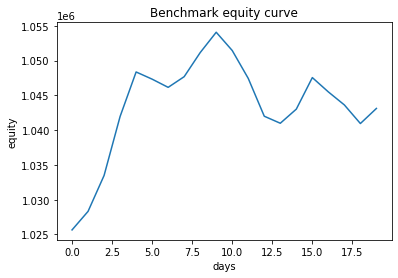

In [39]:
plt.plot(days_list, benchmark_equity_list)
plt.xlabel('days')
plt.ylabel('equity')
plt.title('Benchmark equity curve')

Text(0.5, 1.0, 'Sample strategy (top stocks) equity curve')

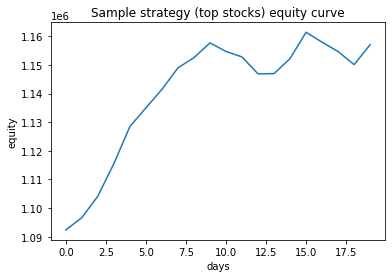

In [40]:
plt.plot(days_list, top_equity_list)
plt.xlabel('days')
plt.ylabel('equity')
plt.title('Sample strategy (top stocks) equity curve')

Text(0.5, 1.0, 'nifty50 equity curve')

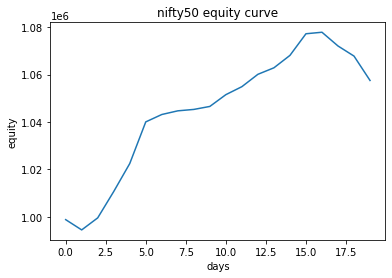

In [42]:
plt.plot(days_list, nifty_y_pred)
plt.xlabel('days')
plt.ylabel('equity')
plt.title('nifty50 equity curve')

In [45]:
print("Top stocks selected are \n", best_stocks)

Top stocks selected are 
 ['BAJAJFINSV.NS', 'ADANIENT.NS', 'EICHERMOT.NS', 'AXISBANK.NS', 'BHARTIARTL.NS', 'COALINDIA.NS', 'CIPLA.NS', 'INDUSINDBK.NS', 'M&M.NS', 'TITAN.NS']


**Performance metrics**

In [62]:
# CAGR
CAGR_sample = (pow(top_equity_list[-1]/top_equity_list[0], 365/len(top_equity_list)) - 1)*100
print(CAGR_sample)
CAGR_benchmark = (pow(benchmark_equity_list[-1]/benchmark_equity_list[0], 365/len(benchmark_equity_list)) - 1)*100
print(CAGR_benchmark)
CAGR_nifty = (pow(nifty_y_pred[-1]/nifty_y_pred[0], 365/len(nifty_y_pred)) - 1)*100
print(CAGR_nifty)

185.53361061586645
36.11506326998391
183.56648726472594


Text(0.5, 1.0, 'sample strategy daily returns')

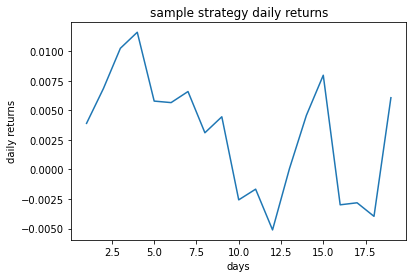

In [68]:
# daily returns of sample strategy
top_daily_returns = []
for i in range(1, len(top_equity_list)):
  top_daily_returns.append((top_equity_list[i]/top_equity_list[i-1]) - 1)
plt.plot(days_list[1:], top_daily_returns)
plt.xlabel('days')
plt.ylabel('daily returns')
plt.title('sample strategy daily returns')

Text(0.5, 1.0, 'benchmark strategy daily returns')

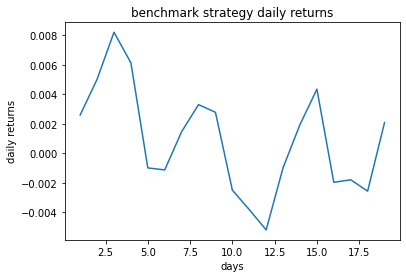

In [71]:
# daily returns of benchmark strategy
benchmark_daily_returns = []
for i in range(1, len(benchmark_equity_list)):
  benchmark_daily_returns.append((benchmark_equity_list[i]/benchmark_equity_list[i-1]) - 1)
plt.plot(days_list[1:], benchmark_daily_returns)
plt.xlabel('days')
plt.ylabel('daily returns')
plt.title('benchmark strategy daily returns')

Text(0.5, 1.0, 'nifty50 daily returns')

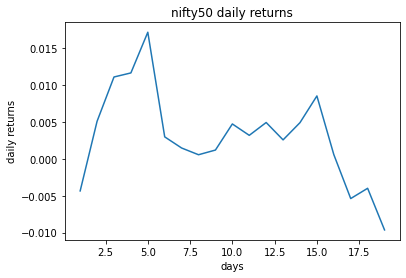

In [72]:
# daily returns of nifty50
nifty_daily_returns = []
for i in range(1, len(nifty_y_pred)):
  nifty_daily_returns.append((nifty_y_pred[i]/nifty_y_pred[i-1]) - 1)
plt.plot(days_list[1:], nifty_daily_returns)
plt.xlabel('days')
plt.ylabel('daily returns')
plt.title('nifty50 daily returns')

In [74]:
# volatility
sample_volatility = (pow(statistics.stdev(top_daily_returns), 1/252))*100
print(sample_volatility)
benchmark_volatility = (pow(statistics.stdev(benchmark_daily_returns), 1/252))*100
print(benchmark_volatility)
nifty_volatility = (pow(statistics.stdev(nifty_daily_returns), 1/252))*100
print(nifty_volatility)

97.92136747343405
97.79287262093321
98.01562086251687


In [79]:
# sharpe ratio
sample_sharpe_ratio = pow(statistics.mean(top_daily_returns)/statistics.stdev(top_daily_returns), 1/252)
print(sample_sharpe_ratio)
benchmark_sharpe_ratio = pow(statistics.mean(benchmark_daily_returns)/statistics.stdev(benchmark_daily_returns), 1/252)
print(benchmark_sharpe_ratio)
nifty_sharpe_ratio = pow(statistics.mean(nifty_daily_returns)/statistics.stdev(nifty_daily_returns), 1/252)
print(nifty_sharpe_ratio)

0.9980107807013104
0.9944851781034858
0.9970346893931895
